# Early Model Testing

In [4]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import seaborn as sns
import os
import time
from sklearn.ensemble import RandomForestRegressor

### Load dataset

In [5]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)
originalSize = original_data.shape[1]
original_data.head()
original_data.shape

(139678, 535)

## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [6]:
start_time = '2012-02-01 00:00:00'
#start_time = '2014-02-01 00:00:00'
splitting_point = int(0.9 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

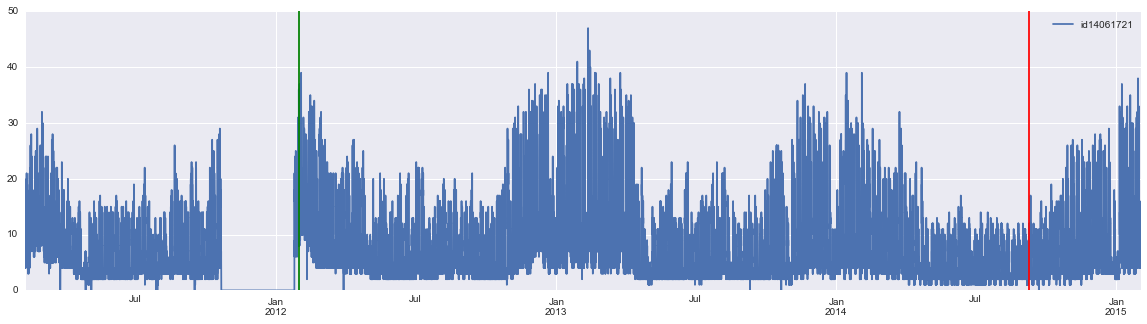

In [7]:
f = original_data[["id14061721"]].plot(figsize=(20,5)) 
original_data.iloc(splitting_point)
f.axvline(start_time, color='g')
f.axvline(splitting_time, color='r')

## Feature Importances

Mean importances of all sensors

In [ ]:
autoregressive_cols = ['measurement', 'shifted_measurement_1d', 'shifted_measurement_2d', 'shifted_measurement_1w', 
                       'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_mean_d', 
                       'measurement_roll_mean_w', 'measurement_roll_mean_m', 'measurement_roll_min2_d',
                       'measurement_roll_min2_w', 'measurement_roll_max2_d', 'measurement_roll_max2_w',
                       'measurement_roll_var_6h', 'measurement_roll_var_d', 'measurement_roll_var_w']

wetaher_current_cols =  ['p', 't2m_termin', 'rh_termin', 'padavine', 'veter_hitrost', 'veter_vek_smer', 'energija_gl',
 'energija_di', 'p_roll_mean_1h', 'p_roll_mean_6h', 'p_roll_mean_d', 'p_roll_mean_w', 'p_roll_mean_m', 'p_roll_var_1h',
 'p_roll_var_d', 't2m_termin_roll_mean_1h', 't2m_termin_roll_mean_6h', 't2m_termin_roll_mean_d', 't2m_termin_roll_mean_w',
 't2m_termin_roll_mean_m', 't2m_termin_roll_min2_d', 't2m_termin_roll_min2_w', 't2m_termin_roll_max2_d',
 't2m_termin_roll_max2_w', 't2m_termin_roll_var_1h', 't2m_termin_roll_var_d', 'rh_termin_roll_mean_1h',
 'rh_termin_roll_mean_6h', 'rh_termin_roll_mean_d', 'rh_termin_roll_mean_w', 'rh_termin_roll_mean_m',
 'rh_termin_roll_min2_d', 'rh_termin_roll_min2_w', 'rh_termin_roll_max2_d', 'rh_termin_roll_max2_w',
 'rh_termin_roll_var_1h', 'rh_termin_roll_var_d', 'energija_gl_roll_mean_1h', 'energija_gl_roll_mean_6h',
 'energija_gl_roll_mean_d', 'energija_gl_roll_mean_w', 'energija_gl_roll_mean_m', 'energija_gl_roll_var_1h',
 'energija_gl_roll_var_d']

weather_forecasted_cols =  ['shifted_p', 'shifted_t2m_termin', 'shifted_rh_termin', 'shifted_padavine', 
                            'shifted_veter_hitrost', 'shifted_veter_vek_smer', 'shifted_energija_gl']

date_time_cols =  ['shifted_HourOfDay', 'shifted_DayOfWeek', 'shifted_Month', 'shifted_Weekday', 'shifted_Weekend', 
                   'shifted_Holiday', 'shifted_DayBeforeHoliday', 'shifted_DayAfterHodliay', 'shifted_BusinessDay', 
                   'shifted_BusinessDay_sum', 'shifted_Holiday_sum']

feature_importances = pd.DataFrame(columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'horizon']))
feature_importances.index.name = "Feature"

In [ ]:
sensors_list = list(data)[:30] # Sensor ids (30)

for sensor_name in sensors_list:
    print "Working with sensor: {}".format(sensor_name)
    
    # Create dataframe for specific sensor
    sensor_cols_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
    sensor_data_cols = [col for col in list(data) if col not in sensor_cols_to_drop]
    sensor_data = data[sensor_data_cols]
    
    # Replace 'sensor id' column names with 'measurement'
    sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)
    
    # Prepare columns to shift
    columnsToShift = list(sensor_data)
    shiftedColumns = ["shifted_" + col for col in columnsToShift]
    
    # Prepare datasets
    #measurements_cols = [col for col in list(sensor_data) if col.startswith('measurement')]    
    all_cols = autoregressive_cols + wetaher_current_cols + weather_forecasted_cols + date_time_cols 

    for horizon in range (1,25):
        print "Horizon: {}h".format(horizon)
        
        sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
        sensor_data.dropna(inplace=True)

        training_data = sensor_data[:splitting_time]
        testing_data = sensor_data[splitting_time:]

        model = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=32)

        X_train = training_data[all_cols].values
        y_train = training_data[["shifted_measurement"]].values.ravel()

        X_test = testing_data[all_cols].values
        y_test = testing_data[["shifted_measurement"]].values.ravel()

        start = time.time() # Start measuring time
        model.fit(X_train,y_train)
        runtime = time.time() - start # Calculate runtime

        feature_importances.loc[:,(sensor_name, horizon)] = model.feature_importances_

feature_importances.index = all_cols # Replaces index names
#feature_importances

Working with sensor: id14061671
Horizon: 1h

D:\Users\bkazic\Envs\py27_64bit\lib\site-packages\pandas\core\frame.py:2524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
D:\Users\bkazic\Envs\py27_64bit\lib\site-packages\pandas\core\frame.py:2148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]



Horizon: 2h

In [ ]:
output_file_name = "featureImportanceResultsAllNew.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

feature_importances.to_csv(output_file_path)

Compute means of all sensors

In [ ]:
feature_importances_all = feature_importances.groupby(level='horizon',axis=1).mean()
feature_importances_all

In [ ]:
output_file_name = "featureImportanceResultsNew.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

feature_importances_all.to_csv(output_file_path)

In [ ]:
#import seaborn as sns
sns.set(context="paper", font="monospace")
sns.set_style("white")

f, ax = plt.subplots(figsize=(30, 40))
sns.heatmap(feature_importances_all, square=True, annot=True, annot_kws={"size": 8}, fmt=".2f", cbar=False)
plt.title("Feature Importances")
plt.savefig("./figures/featureImportanceAll.pdf")
plt.savefig("./figures/featureImportanceAll.png", dpi=300)

## Top 20 Features of All Time

In [ ]:
feature_importances_all_mean = feature_importances_all.mean(axis=1)
feature_importances_all_mean.sort(ascending=False, inplace=True)
feature_importances_all_mean[:20]

Replace index names

In [ ]:
top20_indices = np.argsort(list(feature_importances_all.mean(axis=1)))[::-1][0:20]
top20 = feature_importances_all.ix[top20_indices]
#top20

In [ ]:
#top20_indices = np.argsort(list(feature_importances_all.mean(axis=1)))[::-1][0:20]

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(top20, square=True, annot=True, annot_kws={"size": 8}, fmt=".2f", cbar=False)
plt.title("Feature Importances: Top 20")
plt.tight_layout()
plt.savefig("./figures/featureImportanceTop20.pdf")
plt.savefig("./figures/featureImportanceTop20.png", dpi=300)

In [ ]:
top20_indices = np.argsort(list(feature_importances_all.mean(axis=1)))[::-1][0:20]
top20 = feature_importances_all.ix[top20_indices]
"""
new_index_names = ["measurement_MA_d", "measurement_MA_6h", "hour_of_day", "measurement_minus_1d",
                   "forecasted_global_radiation", 
                   "measurement_MA_h", "measurement_VAR_d", "measurement_VAR_6h", "global_radiation_MA_6h", 
                   "measurement_MIN_d", "business_day", "measurement_MIN_d", "gl_radiation_MA_h", "global_radiation", 
                   "day_of_week", "diffusive_radiation", "forecasted_temperature", "measurement_MA_w", "temperature_MA_6h", 
                   "measurement_MA_m"]
"""
new_index_names = ["hour_of_day", "measurement_MA_6h", "forecasted_global_radiation", "business_day", "measurement",
                   "measurement_MA_d", "measurement_MA_h", "measurement_VAR_w", "measurement_MAX_w", "measurement_MA_w",
                   "day_of_week", "global_radiation_MA_6h", "measurement_VAR_6h", "temperature_MA_m", "global_radiation_MA_h",
                   "forecasted_temperature", "preassure_VAR_d", "measurement_MA_m", "global_radiation_MA_m", "global_radiation"]
top20.index=new_index_names
top20

In [ ]:
#top20_indices = np.argsort(list(feature_importances_all.mean(axis=1)))[::-1][0:20]

f, ax = plt.subplots(figsize=(8, 6.5))
sns.heatmap(top20, square=True, annot=True, annot_kws={"size": 6.5}, fmt=".2f", cbar=False)
plt.title("Feature Importances: Top 20")
plt.tight_layout()
plt.savefig("./figures/featureImportanceTop20.pdf")
plt.savefig("./figures/featureImportanceTop20.png", dpi=300)

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

ax = feature_importances_all_mean[:20][::-1].plot(kind='barh', figsize=(13,8))
sns.set_style("whitegrid")
    
plt.savefig("./figures/listOfTop20Features.png", dpi=300)

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

#ax = feature_importances_all_mean[:20].plot(kind='bar', figsize=(12,5), title="Feature Importance: Top 20")
ax = top20.mean(axis=1).plot(kind='bar', figsize=(8,4), title="Feature Importance: Top 20")
sns.set_style("whitegrid")
for p in ax.patches:
    ax.annotate(str("%.2f" % p.get_height()), (p.get_x() , p.get_height() * 1.02), fontsize=8)
plt.tight_layout()
plt.savefig("./figures/listOfTop20Features.png", dpi=300)